In [1]:
import requests
import os
import re
import random
import urllib.request

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [2]:
def parse_reverse_line_w_rhyme(text):
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}
    rhyme_pairs = []

    #99 and 126 do not strictly follow format
    for i in range(154):
        if i+1 == 99 or i+1 == 126: continue
        sonnet_start = i * 15
        if 99 < i+1 < 126: sonnet_start += 1
        elif i+1 > 126: sonnet_start -= 1
        for j in range(3):
            rhyme_pairs.append([lines[sonnet_start+1+j*4][-1], lines[sonnet_start+1+j*4+2][-1]])
            rhyme_pairs.append([lines[sonnet_start+1+j*4+1][-1], lines[sonnet_start+1+j*4+3][-1]])
            for k in range(4):
                obs_elem = []
                line = lines[sonnet_start+1+j*4+k]
                for word in line:
                    word = re.sub(r'[^\w\']', '', word).lower()
                    if word not in obs_map:
                        obs_map[word] = obs_counter
                        obs_counter += 1
                    obs_elem.insert(0, obs_map[word])
                obs.append(obs_elem)
        rhyme_pairs.append([lines[sonnet_start+13][-1], lines[sonnet_start+14][-1]])
        for k in range(2):
            obs_elem = []
            line = lines[sonnet_start+13+k]
            for word in line:
                word = re.sub(r'[^\w\']', '', word).lower()
                if word not in obs_map:
                    obs_map[word] = obs_counter
                    obs_counter += 1
                obs_elem.insert(0, obs_map[word])
            obs.append(obs_elem)
    rhyme_pairs = [[re.sub(r'[^\w\']', '', w).lower() for w in p] for p in rhyme_pairs]
    
    return obs, obs_map, rhyme_pairs

In [3]:
from Emily_project3_helper import *
shakespeare = open("shakespeare.txt", "r").read()

In [4]:
reversed_lines, word_map, rhymes = parse_reverse_line_w_rhyme(shakespeare)

In [5]:
hmm_rhyme_15_hidden = unsupervised_HMM(reversed_lines, 15, 10)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


In [6]:
def get_state(O, obs, L):
    prob = [O[i][obs] for i in range(len(O))]
    prob = [p/sum(prob) for p in prob]
    return np.random.choice(L, p=prob)

from poem_utils import parse_syllable_dict, line_syllable_count

def get_line_w_ending(hmm, obs_map, end):
    obs = obs_map[end]
    obs_map_r = obs_map_reverser(obs_map)
    init_s = get_state(hmm.O, obs, hmm.L)
    states = [init_s]
    sentence = [end]
    for _ in range(7):
        s = np.random.choice(range(hmm.L), p=hmm.A[states[-1]])
        states.append(s)
        e = np.random.choice(range(hmm.D), p=hmm.O[s])
        sentence.insert(0, obs_map_r[e])
    return sentence

syllable_dict = parse_syllable_dict()

def get_line_w_ending_syllables(hmm, obs_map, end, n_syllables=10):
    line = get_line_w_ending(hmm, obs_map, end)
    while n_syllables not in line_syllable_count(line, syllable_dict):
        line = get_line_w_ending(hmm, obs_map, end)
    return ' '.join(line).capitalize()

def rhyme_sample_sonnet(hmm, obs_map, rhymes, seed=None):
    rng = np.random.default_rng(seed=seed)
    sonnet = []
    
    for i in range(3):
        r = rng.choice(len(rhymes), 2)
        end_words = [rhymes[r[0]][0], rhymes[r[1]][0], rhymes[r[0]][1], rhymes[r[1]][1]]
        stanza = [get_line_w_ending_syllables(hmm, obs_map, end) for end in end_words]
        stanza.append('\n')
        sonnet.append('\n'.join(stanza))
    rhyme_choice = rng.choice(len(rhymes))
    stanza = [get_line_w_ending_syllables(hmm, obs_map, rhymes[rhyme_choice][0]), 
              get_line_w_ending_syllables(hmm, obs_map, rhymes[rhyme_choice][1])]
    sonnet.append('\n'.join(stanza))
    
    return '\n'.join(sonnet)

{"'gainst": ([1], []), "'greeing": ([2], [1]), "'scaped": ([1], []), "'tis": ([1], []), "'twixt": ([1], []), 'a': ([1], []), 'a-doting': ([3], [2]), 'abhor': ([2], []), 'abide': ([2], []), 'able': ([2], []), 'about': ([2], []), 'above': ([2], []), 'absence': ([2], []), 'absent': ([2], []), 'abundance': ([3], []), 'abundant': ([3], []), 'abuse': ([2], []), 'abused': ([2], []), 'abuses': ([3], []), 'abysm': ([2], []), 'accents': ([2], []), 'acceptable': ([4], []), 'acceptance': ([3], []), 'accessary': ([4], []), 'accident': ([3], []), 'accidents': ([3], []), 'account': ([2], []), 'accumulate': ([4], []), 'accuse': ([2], []), 'accusing': ([3], []), 'achieve': ([2], []), 'acknowledge': ([3], []), 'acquaintance': ([3], []), 'acquainted': ([3], [2]), 'act': ([1], []), 'action': ([2], []), 'active': ([2], []), 'actor': ([2], []), 'add': ([1], []), 'added': ([2], []), "adder's": ([2], []), 'addeth': ([2], []), 'adding': ([2], []), 'addition': ([3], []), 'adieu': ([2], []), 'adjunct': ([2], [])

In [7]:
print(rhyme_sample_sonnet(hmm_rhyme_15_hidden, word_map, rhymes))

Face one my nature unused some past as
Time love worldwithoutend the summer do is so
Place of canker bonds fortune's waste to gives
Prime thy though to is placed not augurs


Find from me be virgin be rudely stones
Pen but summer's be cast pleasure mars light's
Mind and mine be for graciously more are
Men thy habit legions but with it with


Muse veil heavy be out bloody to but
This sparkling hath make is the for truetelling
Use sweetest run'st up if it keeps flattered
Kiss time even the doth those my neither


See wood's and which must motley your children's
Be hap but did invention seem not all


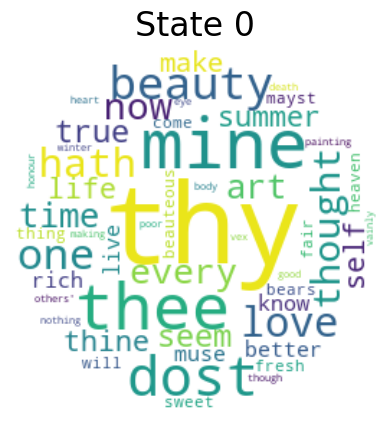

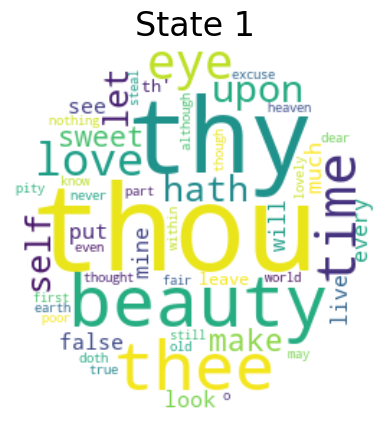

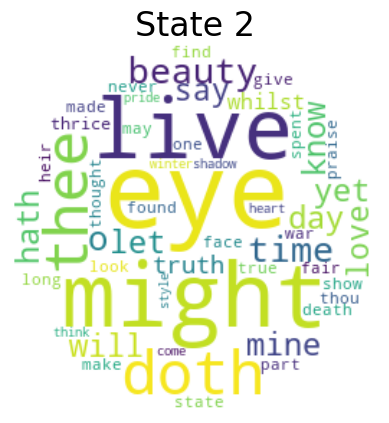

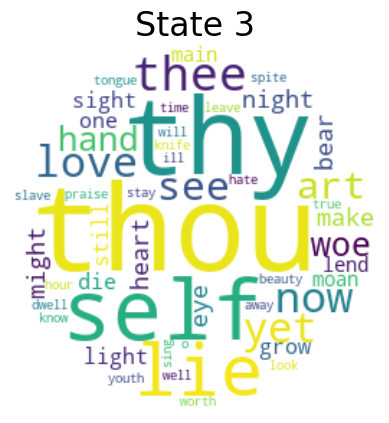

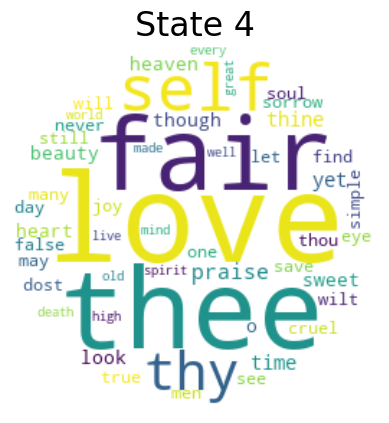

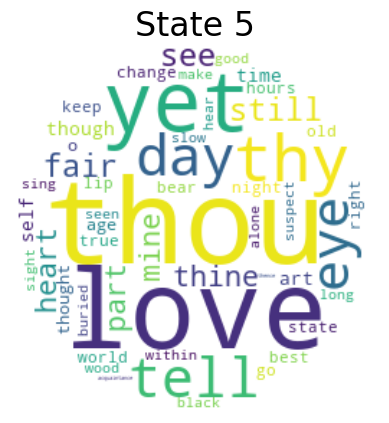

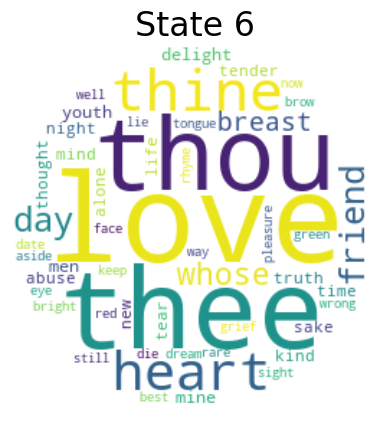

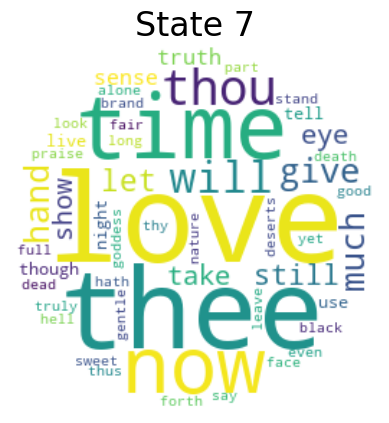

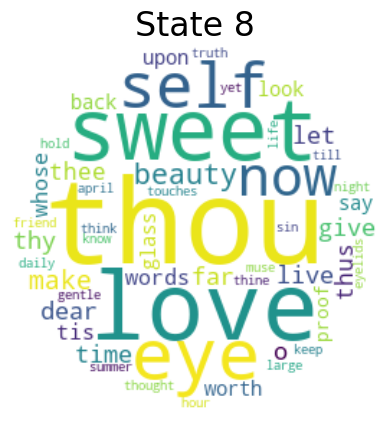

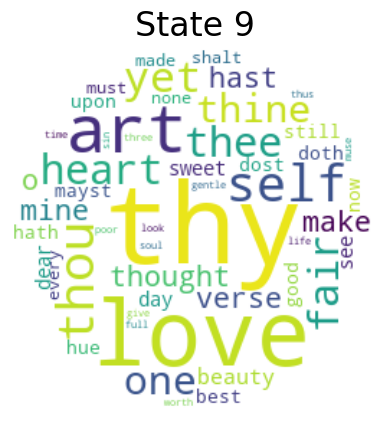

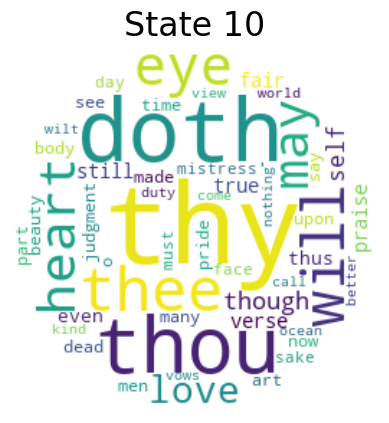

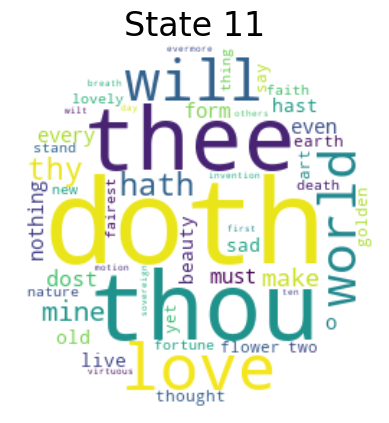

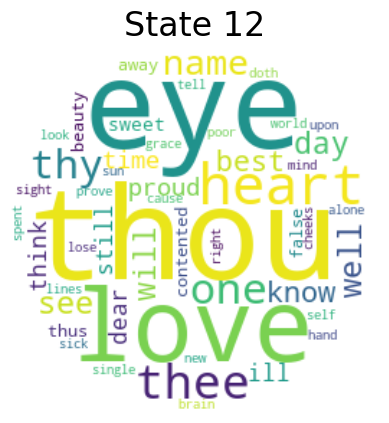

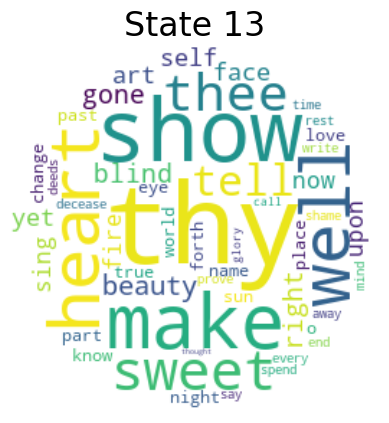

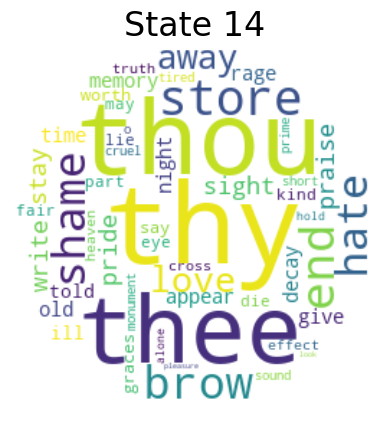

In [8]:
wordclouds = states_to_wordclouds(hmm_rhyme_15_hidden, word_map)